In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time

In [2]:
from tokenize_data import process

train_directory = '/home/a_stasiuk/bsuir_ml_part2/data/aclImdb/train'
test_directory = '/home/a_stasiuk/bsuir_ml_part2/data/aclImdb/test'


train_vectors, train_labels = process(train_directory, mode='train', format='bag-word')
test_vectors, test_labels = process(test_directory, mode='test', format='bag-word')

  1%|▏         | 39/3000 [00:00<00:07, 385.91it/s]

/home/a_stasiuk/bsuir_ml_part2/data/aclImdb/train/pos


  1%|▏         | 38/3000 [00:00<00:08, 367.12it/s]

/home/a_stasiuk/bsuir_ml_part2/data/aclImdb/train/neg


  2%|▏         | 45/3000 [00:00<00:06, 437.31it/s]

/home/a_stasiuk/bsuir_ml_part2/data/aclImdb/test/pos


  1%|▏         | 42/3000 [00:00<00:07, 416.26it/s]

/home/a_stasiuk/bsuir_ml_part2/data/aclImdb/test/neg


100%|██████████| 3000/3000 [00:07<00:00, 412.88it/s]


In [3]:
batch_size = 1024
train_data = TensorDataset(torch.Tensor(train_vectors), torch.Tensor(train_labels))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data = TensorDataset(torch.Tensor(test_vectors), torch.Tensor(test_labels))
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

In [4]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [5]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden


In [61]:
# Setting common hyperparameters
input_dim = next(iter(train_loader))[0].shape[1]
#     print(input_dim)
output_dim = 1
hidden_dim=512
n_layers = 10
learn_rate = 0.01

model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

In [62]:
from sklearn.metrics import mean_squared_error

def eval(model, val_loader, batch_size, device):
    model.eval()
    
    total = 0
    correct = 0
    for x, label in val_loader:
        x.unsqueeze_(0)
        x = x.permute(1,0,2)
        h = model.init_hidden(batch_size)
        out, h = model(x.to(device).float(), h)
#         print(out)
        out = torch.flatten(out)
        predicted = out.cuda().round()
#         _, predicted = torch.max(out, 1)

        total += label.size(0)
        
#         print(predicted, label)
#         break

        correct += mean_squared_error(predicted.cpu().detach().numpy(), label.cpu().detach().numpy())
    accuracy = float(correct/len(val_loader))
    print(accuracy)
    return(accuracy)
        
    
    
from tqdm import tqdm

def train(model, criterion, optimizer, train_loader, batch_size, device, EPOCHS=20):    
    losses = {}
    for epoch in tqdm(range(EPOCHS)):
        model.train()
        h = model.init_hidden(batch_size)
        running_loss = 0
        for x, label in train_loader:
            h = h.data
            model.zero_grad()
            
            x.unsqueeze_(0)
            x = x.permute(1,0,2)
            x = x.to(device).float()
            
            out, h = model(x, h)
            out = torch.flatten(out)
            
            label = label.to(device).float()
            
            loss = criterion(out, label)
            loss.backward()
            optimizer.step()
            
            running_loss += loss
        losses[epoch] = running_loss/len(train_loader)
        eval(model, test_loader, batch_size, device)
            
    return (model, losses)

In [63]:
gru_model, losses = train(model, criterion, optimizer, train_loader, batch_size, device, EPOCHS=20)

 10%|█         | 2/20 [00:00<00:03,  5.17it/s]

0.5859375
0.5859375


 15%|█▌        | 3/20 [00:00<00:03,  5.25it/s]

0.4140625


 25%|██▌       | 5/20 [00:01<00:03,  4.98it/s]

0.5859375
0.4140625


 35%|███▌      | 7/20 [00:01<00:02,  5.21it/s]

0.4140625
0.5859375


 45%|████▌     | 9/20 [00:01<00:02,  5.35it/s]

0.4140625
0.4140625


 55%|█████▌    | 11/20 [00:02<00:01,  5.42it/s]

0.5859375
0.4140625


 65%|██████▌   | 13/20 [00:02<00:01,  5.10it/s]

0.5859375
0.5859375


 75%|███████▌  | 15/20 [00:02<00:00,  5.29it/s]

0.4140625
0.5859375


 85%|████████▌ | 17/20 [00:03<00:00,  5.38it/s]

0.4140625
0.4140625


 95%|█████████▌| 19/20 [00:03<00:00,  5.44it/s]

0.5859375
0.4140625


100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

0.5859375


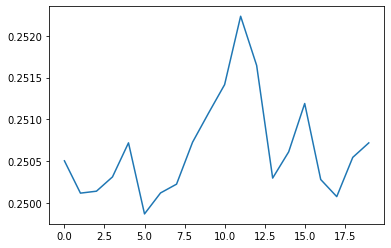

In [60]:
import matplotlib.pyplot as plt

plt.plot(list(losses.keys()), list(losses.values()))
plt.show()